In [234]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm

from dpp.data.network import PPINetwork
from dpp.util import Params, prepare_sns
from dpp.data.associations import load_diseases
from dpp.experiments.protein_significance import ProteinSignificance
os.chdir("/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Protein Significance

In [2]:
protein_sig_df = pd.read_csv("experiments/protein_significance/samples_1000/results.csv")

In [3]:
protein_sig_df.keys()

Index(['disease', 'protein', 'common_interactor_score',
       'common_interactor_score_pvalue', 'degree', 'frac_direct_interactions',
       'frac_direct_interactions_pvalue'],
      dtype='object')

In [28]:
ci_sig = protein_sig_df["common_interactor_score_pvalue"] < 0.05
di_sig = protein_sig_df["frac_direct_interactions_pvalue"] < 0.05 

In [34]:
ci_sig_di_nsig = np.logical_and(ci_sig, np.logical_not(di_sig))
ci_nsig_di_sig =  np.logical_and(di_sig, np.logical_not(ci_sig))

In [32]:
np.mean(ci_sig_di_nsig)

0.15384716941275878

In [35]:
np.mean(ci_nsig_di_sig)

0.021216201943388257

In [17]:
np.mean(di_sig)

0.17782266582171524

In [18]:
np.mean(ci_sig)

0.3104536332910858

In [36]:
np.mean(ci_sig) - np.mean(ci_sig_di_nsig)

0.156606463878327

In [37]:
np.mean(di_sig) - np.mean(ci_nsig_di_sig)

0.156606463878327

In [41]:
np.mean(protein_sig_df["frac_direct_interactions"] == 0)

0.46511934938741023

## DPP Performance

In [235]:
dpp_df = pd.read_csv("experiments/aggregation/full_aggregation/results.csv", header=[0, 1], index_col=0)

#### Size

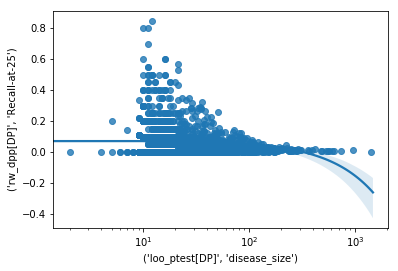

In [361]:
sns.regplot(x=dpp_df["loo_ptest[DP]", "disease_size"], 
                y=dpp_df["rw_dpp[DP]", "Recall-at-25"])
plt.xscale("log")

In [428]:
dpp_df_large = dpp_df.nlargest(n=30, columns=[("loo_ptest[DP]", "disease_size")])

In [429]:
dpp_df_large["lci_dpp[DP]", "Recall-at-25"].mean()

0.023919733347122198

In [430]:
dpp_df_large["rw_dpp[DP]", "Recall-at-25"].mean()

0.009659373339799824

In [431]:
dpp_df_large["diamond_dpp[DP]", "Recall-at-25"].mean()

0.01016710549544933

In [424]:
dpp_df_small = dpp_df.nsmallest(n=30, columns=[("loo_ptest[DP]", "disease_size")])

In [425]:
dpp_df_small["lci_dpp[DP]", "Recall-at-25"].mean()

0.12771164021164022

In [426]:
dpp_df_small["rw_dpp[DP]", "Recall-at-25"].mean()

0.05587301587301588

In [427]:
dpp_df_small["diamond_dpp[DP]", "Recall-at-25"].mean()

0.05832010582010582

### Performance

In [319]:
(dpp_df["lci_dpp[DP]", "Recall-at-25"] > 0).mean()

0.6940916620651574

In [337]:
def top_k(method, metric="Recall-at-25", k=100):
    return dpp_df[method, metric].nlargest(k).mean()

In [338]:
print(f"LCI: {top_k('lci_dpp[DP]')}")
print(f"DIAMOND: {top_k('diamond_dpp[DP]')}")
print(f"RW: {top_k('rw_dpp[DP]')}")

LCI: 0.4672023809523811
DIAMOND: 0.3889682539682539
RW: 0.3836833333333333


In [284]:
top_k("rw_dpp[DP]")

0.3287333333333333

In [294]:
# difference in recall-at-25
comparison = "rw"
diff = (dpp_df["lci_dpp[DP]", "Recall-at-25"] - dpp_df[f"{comparison}_dpp[DP]", "Recall-at-25"] >= 0).mean()
diff_df = pd.DataFrame(dpp_df["lci_dpp[DP]", "Recall-at-100"] - dpp_df[f"{comparison}_dpp[DP]", "Recall-at-100"],
                 columns=["diff"])
diff_df.index.name = "id"
print(diff)

0.7990060739922694


In [438]:
# difference in recall-at-25
comparison = "rw"
diff = (dpp_df["lci_dpp[DP]", "Recall-at-100"] - dpp_df[f"{comparison}_dpp[DP]", "Recall-at-100"] >= 0).mean()

diff_df = pd.DataFrame(dpp_df["lci_dpp[DP]", "AUROC"] - dpp_df[f"{comparison}_dpp[DP]", "AUROC"],
                 columns=["diff"])
diff_df.index.name = "id"
print(diff)

0.7603533959138598


In [455]:
np.max(dpp_df["rw_dpp[DP]", "Recall-at-25"] - rw_df["Recall-at-25"])

6.938893903907228e-18

In [458]:
((dpp_df["lci_dpp[DP]", "Recall-at-25"] - dpp_df["rw_dpp[DP]", "Recall-at-25"]) >= 0).mean()

0.7990060739922694

In [156]:
lci_recall_100 = dpp_df["lci_dpp[DP]", "Recall-at-100"]
lci_name = dpp_df["data", "name"]
gcn_recall_100 = pd.read_csv("experiments/dpp_evaluate/gcn/metrics.csv", index_col=0)["Recall-at-100"].loc[lci_recall_100.index]
df = pd.DataFrame({"gcn_recall_100": gcn_recall_100, "lci_recall_100": lci_recall_100, 'name':lci_name})
df.to_csv("experiments/dpp_evaluate/gcn/lcivgcn.csv")

In [157]:
dpp_recall_100 = dpp_df["lci_dpp[DP]", "Recall-at-100"]

In [295]:
# difference in recall-at-25
comparison = "diamond"
(dpp_df["lci_dpp[DP]", "Recall-at-25"] - dpp_df[f"{comparison}_dpp[DP]", "Recall-at-25"] >= 0).mean()

0.8415240198785201

In [159]:
# difference in recall-at-25
comparison = "node2vec"
(dpp_df["lci_dpp[DP]", "Recall-at-25"] - dpp_df[f"{comparison}_dpp[DP]", "Recall-at-25"] >= 0).mean()

0.9099944781888459

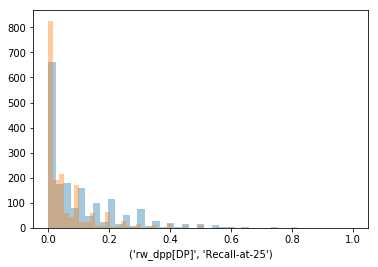

In [343]:
sns.distplot( dpp_df["lci_dpp[DP]", "Recall-at-25"], kde=False)
sns.distplot( dpp_df["rw_dpp[DP]", "Recall-at-25"], kde=False)

In [252]:
dpp_df.describe().loc["mean"]

loo_ptest[DP]         disease_size                         41.824406
                      pvalue_COMP                           0.081082
                      pvalue_DNS                            0.227300
lci_dpp[DP]           Recall-at-100                         0.185179
                      Recall-at-25                          0.101982
                      AUROC                                 0.794807
                      Mean Average Precision                0.029788
lci_dpp[0.3][DP]      Recall-at-100                         0.181511
                      Recall-at-25                          0.095883
                      AUROC                                 0.794473
                      Mean Average Precision                0.028717
ci_dpp[DP]            Recall-at-100                         0.174387
                      Recall-at-25                          0.094328
                      AUROC                                 0.769323
                      Mean Average

In [527]:
lci_df = dpp_df["lci_dpp[DP]", "Recall-at-25"]
name_df = dpp_df["data", "name"]
comp_df = dpp_df["rw_dpp[DP]", "Recall-at-25"]
diff_df = lci_df - comp_df
diff_df.name = "diff"
diff_df = pd.DataFrame(name_df).join(diff_df)
diff_df.loc[diff_df[('data', 'name')] == "Arnold Chiari Malformation"]


/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction/env/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(data, name)",diff
id,,
C0003803,Arnold Chiari Malformation,0.300


In [528]:
diff_df.loc[diff_df[('data', 'name')] == "Arnold Chiari Malformation"]

,"(data, name)",diff
id,,
C0003803,Arnold Chiari Malformation,0.300


In [529]:
with pd.option_context('display.max_rows', None, 'display.max_columns', diff_df.shape[1]):
    diff_df = diff_df.sort_values("diff")
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    diff_df.style.format("{:.1f}")
    print(diff_df)

                                               (data, name)   diff
id                                                                
C1833999                    Pigmentary retinal degeneration -0.350
C1855038                            Hepatocellular necrosis -0.300
C0018995                                    Hemochromatosis -0.300
C1276035                       Pena-Shokeir syndrome type I -0.300
C0265215                             Meckel-Gruber syndrome -0.250
C0085159                        Seasonal Affective Disorder -0.250
C4020869                         Abnormality of the abdomen -0.250
C1837388                      Abnormal respiratory patterns -0.250
C0002994                                         Angioedema -0.222
C0033805                            Pseudohypoaldosteronism -0.200
C0016978                               gallbladder neoplasm -0.200
C1837482                                Thoracic hypoplasia -0.200
C0085612                             Ventricular arrhythmia -0

### Disease Classes

In [160]:
classes_df = pd.read_csv("data/disease_classes/disgenet-classes.csv", index_col=0)

In [161]:
joined_df = diff_df.join(classes_df)

In [162]:
median_df = joined_df.groupby(by="class").median()
order = median_df.sort_values("diff", ascending=False).index

In [175]:
median_df

,diff,size
class,,
acquired metabolic,0.017500,40.5
benign neoplasm,0.050000,23.0
cancer,0.034167,28.0
cardiovascular system,0.035000,25.0
cognitive disorder,0.021522,29.0
endocrine system,0.012500,18.5
gastrointestinal system,0.014286,20.0
hematopoietic system,0.050000,27.0
immune system,0.002381,17.0


No handles with labels found to put in legend.


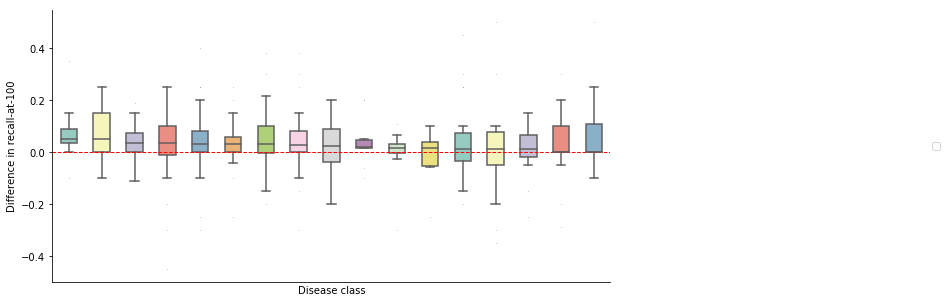

In [163]:
plt.figure(figsize=(10,5))
sns.boxplot(data=joined_df, y="diff", x="class", order=order, hue_order=order, width=0.5, fliersize=0.1, palette="Set3")
plt.axhline(linewidth=1, color='r', linestyle="--")
#plt.ylim((-0.5, 0.5))
sns.despine()
plt.xlabel("Disease class")
plt.xticks([])
plt.legend(loc="right", bbox_to_anchor=(1.6,.5 ))
plt.ylabel("Difference in recall-at-100")
plt.savefig("experiments/dpp_evaluate/_figures/disease_classes/disease_class_box.pdf")

In [223]:
frac_dict = {}
for group in  joined_df.groupby("class").groups.keys():
    group_index = joined_df.groupby("class").groups[group]
    frac_non_neg = np.mean(joined_df.loc[group_index]["diff"] >= 0)
    frac_dict[group] = frac_non_neg
    print(f"{group}: {frac_non_neg}")
frac_df = pd.DataFrame.from_dict(frac_dict, orient="index", columns=["diff"])


acquired metabolic : 0.7142857142857143
benign neoplasm: 0.9
cancer: 0.85
cardiovascular system : 0.717391304347826
cognitive disorder: 0.8
endocrine system : 0.7083333333333334
gastrointestinal system : 0.6571428571428571
hematopoietic system : 0.8095238095238095
immune system : 0.7647058823529411
inherited metabolic disorder: 0.7
integumentary system : 0.8
monogenic : 0.7647058823529411
musculoskeletal system : 0.7777777777777778
nervous system : 0.7419354838709677
reproductive system : 0.625
respiratory system : 0.8095238095238095
urinary system : 0.6666666666666666


In [224]:
frac_df

,diff
acquired metabolic,0.714286
benign neoplasm,0.900000
cancer,0.850000
cardiovascular system,0.717391
cognitive disorder,0.800000
endocrine system,0.708333
gastrointestinal system,0.657143
hematopoietic system,0.809524
immune system,0.764706
inherited metabolic disorder,0.700000


In [225]:
order = frac_df.sort_values("diff", ascending=False).index

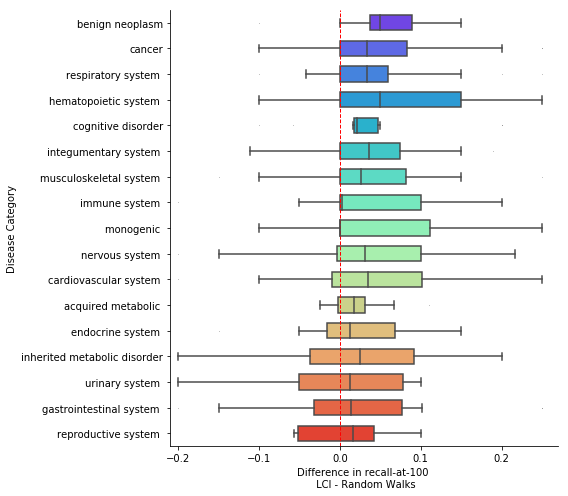

In [227]:
plt.figure(figsize=(8,7))
sns.boxplot(data=joined_df, x="diff", y="class", order=order,
            hue_order=order, width=0.6, fliersize=0.1, palette="rainbow",
            orient="h")
plt.axvline(linewidth=1, color='r', linestyle="--")
sns.despine()
plt.xlim(-0.21, 0.27)
plt.ylabel("Disease Category")
plt.xlabel("Difference in recall-at-100 \n LCI - Random Walks")
plt.tight_layout()
plt.savefig("experiments/dpp_evaluate/_figures/disease_classes/disease_class_box.pdf")

## Gene Ontology Enrichment

In [25]:
lci_go_results = pd.read_csv("experiments/go_enrichment/lci/results.csv", index_col=0)
rw_go_results = pd.read_csv("experiments/go_enrichment/random_walk/results.csv", index_col=0)
lci_go_results

,disease_name,disease_num_significant,disease_top_10,lci_jaccard_sim,lci_num_significant,lci_top_10
C0240063,Coloboma of iris,220,{'regulation of multicellular organismal devel...,0.241135,305,{'negative regulation of biosynthetic process'...
C0029456,Osteoporosis,1241,"{'response to chemical', 'response to stimulus...",0.307042,2007,"{'response to chemical', 'response to oxygen-c..."
C0220994,Hyperammonemia,249,"{'urea cycle', 'carboxylic acid metabolic proc...",0.210526,119,"{'carboxylic acid metabolic process', 'small m..."
C0271388,Pendular Nystagmus,37,"{'sensory perception', 'detection of abiotic s...",0.035294,51,"{'cAMP metabolic process', ""3',5'-cyclic-AMP p..."
C0019196,Hepatitis C,163,"{'response to stress', 'response to stimulus',...",0.000000,1,"{'lipase activity', 'high-density lipoprotein ..."
C1865992,Short hallux,291,{'positive regulation of animal organ morphoge...,0.311321,265,{'enzyme linked receptor protein signaling pat...
C0013604,Edema,751,"{'response to stimulus', 'extracellular region...",0.251466,956,"{'signal transduction', 'cell surface receptor..."
C0018916,Hemangioma,97,{'regulation of cell population proliferation'...,0.007519,37,"{'intracellular organelle lumen', 'vitamin bin..."
C0017574,Gingivitis,0,{'positive regulation of NF-kappaB transcripti...,0.000000,15,"{'supramolecular polymer', 'intermediate filam..."
C0004245,Atrioventricular Block,7,"{'voltage-gated sodium channel complex', 'volt...",0.000000,107,{'inward rectifier potassium channel activity'...


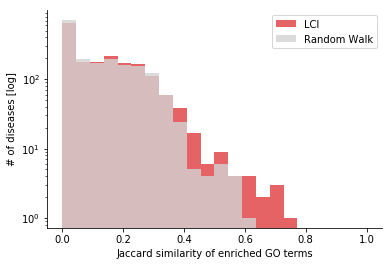

In [12]:
sns.distplot(lci_go_results["lci_jaccard_sim"], bins=22, kde=False, label="LCI", hist_kws={"range": (0, 1),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(rw_go_results["lci_jaccard_sim"], bins=22, kde=False, label="Random Walk", hist_kws={"range": (0, 1),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('log')
plt.xlabel("Jaccard similarity of enriched GO terms")
plt.ylabel("# of diseases [log]")
plt.legend()

In [24]:
lci_median = np.median(lci_go_results['lci_jaccard_sim'])
print(f"LCI Median: {lci_median}")
rw_median = np.median(rw_go_results['lci_jaccard_sim'])
print(f"RW Median: {rw_median}")
percent_increase = (lci_median - rw_median)/rw_median
print(f"Percent Increase: {percent_increase}")

LCI Median: 0.11055276381909547
RW Median: 0.09216589861751152
Percent Increase: 0.19949748743718582
